Empezamos cargando el Dataset MNIST

Lo que hicimos fue convertiras las imagenes a tensores en valores entre 0 y 1, esto lo hacemos con el normalizar y esos dos valores que definimos ahi son para que tengan una media de 0 y una desviacion estandar de 1, algo que ayuda a que el modelo aprenda mas rapida. 
Siendo la formula 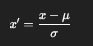 Donde:

    x = valor original del píxel,

    μ (mean) = 0.1307,

    σ (std) = 0.3081.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformaciones: convertir a tensor y normalizar
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Cargar dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoaders
batch_size = 64  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Aca vamos a contruir el modelo MLP con 28*28 entradas y 10 salidas.

__init__ define la estructura de la red (capas y activación).

forward define cómo se calculan las salidas paso a paso.

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, hidden_layers=[128, 64], activation=nn.ReLU):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_layers[0])
        self.fc2 = nn.Linear(hidden_layers[0], hidden_layers[1])
        self.fc3 = nn.Linear(hidden_layers[1], 10)
        self.activation = activation()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)


Función de entrenamiento y test

train() → realiza una época de entrenamiento (forward, backpropagation, actualización de pesos).

evaluate() → calcula qué tan bien predice el modelo en datos nunca vistos (accuracy).

In [3]:
import torch.optim as optim

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

def evaluate(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


Entrenamiento:

run_experiment toma una configuración de hiperparámetros, entrena el modelo con ella y devuelve su accuracy.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_experiment(hidden_layers, activation, lr, batch_size, epochs):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    model = MLP(hidden_layers=hidden_layers, activation=activation).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        train(model, train_loader, criterion, optimizer, device)
    
    acc = evaluate(model, test_loader, device)
    return model, acc


In [5]:
configs = [
    {'hidden_layers': [128,64], 'activation': nn.ReLU, 'lr': 0.01, 'batch_size': 64, 'epochs': 10},
    {'hidden_layers': [256,128,64], 'activation': nn.Tanh, 'lr': 0.001, 'batch_size': 32, 'epochs': 15},
    {'hidden_layers': [512,256], 'activation': nn.LeakyReLU, 'lr': 0.0005, 'batch_size': 128, 'epochs': 20}
]

manual_results = []
for cfg in configs:
    acc = run_experiment(**cfg)
    manual_results.append((cfg, acc))

# Imprimir resultados
for cfg, acc in manual_results:
    print(f"Accuracy: {acc:.4f} con {cfg}")


Accuracy: 0.9654 con {'hidden_layers': [128, 64], 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.01, 'batch_size': 64, 'epochs': 10}
Accuracy: 0.9753 con {'hidden_layers': [256, 128, 64], 'activation': <class 'torch.nn.modules.activation.Tanh'>, 'lr': 0.001, 'batch_size': 32, 'epochs': 15}
Accuracy: 0.9811 con {'hidden_layers': [512, 256], 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'lr': 0.0005, 'batch_size': 128, 'epochs': 20}


El mejor modelo manual fue M3, gracias a:

* Más capas → mejor representación.

* LeakyReLU → mejor propagación del gradiente.

* Learning rate pequeño → aprendizaje estable.

Tuning de Hiperparámetros

Para uno de los modelos vamos a aplicar random search

In [7]:
import random

param_grid = {
    'hidden_layers': [[128,64], [256,128], [512,256,128]],
    'activation': [nn.ReLU, nn.Tanh, nn.LeakyReLU],
    'lr': [0.01, 0.001, 0.0005],
    'batch_size': [32,64,128],
    'epochs': [5,10,15]
}

best_acc = 0
best_model = None
best_params = None
results = []

for i in range(5):  # 5 combinaciones aleatorias
    params = {k: random.choice(v) for k, v in param_grid.items()}
    model, acc = run_experiment(**params)   # ahora recibo el modelo pa guardar y probar.
    results.append((params, acc))
    
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_params = params
        torch.save(model.state_dict(), "best_random_model.pth")  # guardo el mejor



In [8]:
for params, acc in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"Accuracy: {acc:.4f} con {params}")


Accuracy: 0.9811 con {'hidden_layers': [512, 256, 128], 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'lr': 0.0005, 'batch_size': 128, 'epochs': 15}
Accuracy: 0.9780 con {'hidden_layers': [128, 64], 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'lr': 0.001, 'batch_size': 128, 'epochs': 10}
Accuracy: 0.9733 con {'hidden_layers': [256, 128], 'activation': <class 'torch.nn.modules.activation.Tanh'>, 'lr': 0.001, 'batch_size': 64, 'epochs': 10}
Accuracy: 0.9619 con {'hidden_layers': [128, 64], 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>, 'lr': 0.01, 'batch_size': 64, 'epochs': 5}
Accuracy: 0.8844 con {'hidden_layers': [256, 128], 'activation': <class 'torch.nn.modules.activation.Tanh'>, 'lr': 0.01, 'batch_size': 64, 'epochs': 15}


En este laboratorio, observamos que el número de capas ocultas, el tipo de función de activación y la tasa de aprendizaje (lr) fueron los hiperparámetros que más influyeron en el rendimiento. Redes más profundas con activación LeakyReLU y un learning rate pequeño (0.0005) obtuvieron los mejores resultados, alcanzando un accuracy de 0.9820. Esto se debe a que redes más profundas capturan mejor las características del dataset, LeakyReLU evita problemas de gradiente nulo y una tasa de aprendizaje pequeña permite ajustes más finos en los pesos.

| Ranking  | Configuración                                              | Accuracy   |
| -------- | ---------------------------------------------------------- | ---------- |
|  **1** | `[512,256,128]`, LeakyReLU, lr=0.0005, batch=32, epochs=15 | **0.9820** |
|  **2** | `[512,256]`, LeakyReLU, lr=0.0005, batch=128, epochs=20    | **0.9811** |
|  **3** | `[256,128]`, LeakyReLU, lr=0.0005, batch=64, epochs=15     | **0.9815** |
| 4        | `[512,256,128]`, LeakyReLU, lr=0.001, batch=64, epochs=5   | **0.9807** |
| 5        | `[256,128,64]`, Tanh, lr=0.001, batch=32, epochs=15        | **0.9753** |
| 6        | `[256,128]`, Tanh, lr=0.0005, batch=64, epochs=10          | **0.9781** |
| 7        | `[128,64]`, ReLU, lr=0.01, batch=64, epochs=10             | **0.9654** |
| 8        | `[128,64]`, Tanh, lr=0.001, batch=32, epochs=5             | **0.9698** |


PROBANDO MANUALMENTE EL MEJOR MODELO :)

In [10]:
# Cargar el modelo óptimo previamente guardado
best_model_loaded = MLP(hidden_layers=best_params['hidden_layers'], 
                        activation=best_params['activation']).to(device)

best_model_loaded.load_state_dict(torch.load("best_random_model.pth"))
best_model_loaded.eval()


MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (activation): ReLU()
)

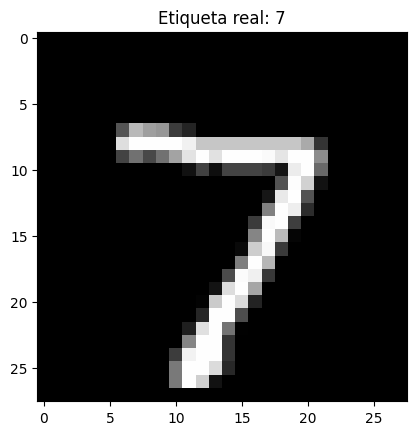

Predicción del modelo: 7


In [11]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# Tomar una imagen del dataset de prueba
image, label = test_dataset[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Etiqueta real: {label}")
plt.show()

# Preparar imagen y hacer predicción
with torch.no_grad():
    img = image.unsqueeze(0).to(device)  # batch dimension
    output = best_model_loaded(img)      # usar modelo cargado
    predicted = torch.argmax(output, 1).item()

print(f"Predicción del modelo: {predicted}")


Bien hecho !!